# Optimization Analysis: Function 3

Vergleich aller Optimierungsansätze auf Function3


## Setup & Imports


In [82]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from indirect_methods import sgd, momentum, rmsprop, adam
from direct_methods import coordinate_search, hooke_jeeves, nelder_mead

# Setze weiße Hintergründe für alle Plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

np.set_printoptions(suppress=True, precision=6)


## BlackBox API


In [83]:
class BlackBox:
    def __init__(self, token: int, endpoint: str = 'http://ls-stat-ml.uni-muenster.de:7300/'):
        self.endpoint = endpoint
        self.token = token
    
    def evaluate(self, objective: str, parameters: list) -> float:
        r = requests.post(url=self.endpoint + "compute/" + objective,
                          json={"parameters": [str(v) for v in parameters], "token": self.token})
        return float(r.json())
    
    def evaluate_gradient(self, objective: str, parameters: list) -> list:
        r = requests.post(url=self.endpoint + "compute_gradient/" + objective,
                          json={"parameters": [str(v) for v in parameters], "token": self.token})
        return r.json()

GROUP_NUMBER = 11
FUNCTION_NAME = "Function3"
bb = BlackBox(token=GROUP_NUMBER)
print(f"✓ BlackBox initialized for {FUNCTION_NAME}")


✓ BlackBox initialized for Function3


## Hyperparameter Configuration

**Hier kannst du die Parameter für jeden Optimizer anpassen:**


In [84]:
# ============================================
# GEMEINSAME PARAMETER
# ============================================
X0 = [-2, -2]           # Startpunkt
MAX_ITER = 200          # Maximale Iterationen
TOLERANCE = 1e-6        # Konvergenz-Toleranz

# ============================================
# GRADIENT-BASED OPTIMIZER
# ============================================
# SGD
sgd_lr = 0.0001

# Momentum
momentum_lr = 0.0001
momentum_beta = 0.9

# RMSProp
rmsprop_lr = 0.01
rmsprop_beta = 0.9

# Adam
adam_lr = 0.05
adam_beta1 = 0.9
adam_beta2 = 0.999

# ============================================
# DIRECT SEARCH OPTIMIZER
# ============================================
# Coordinate Search
coord_step_size = 0.1
coord_reduction = 0.5

# Hooke & Jeeves
hj_step_size = 0.1
hj_reduction = 0.5

# Nelder-Mead
nm_alpha = 1.0
nm_gamma = 2.0
nm_rho = 0.5
nm_sigma = 0.5

print("✓ Hyperparameter konfiguriert")


✓ Hyperparameter konfiguriert


## Function Landscape Visualization


In [85]:
# Erstelle Grid für Visualisierung
x_range = (-5, 5)
y_range = (-5, 5)
resolution = 50

x = np.linspace(x_range[0], x_range[1], resolution)
y = np.linspace(y_range[0], y_range[1], resolution)
X, Y = np.meshgrid(x, y)

print(f"Evaluating {FUNCTION_NAME} on {resolution}x{resolution} grid...")
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = bb.evaluate(FUNCTION_NAME, [X[i, j], Y[i, j]])

print(f"✓ Grid evaluation complete")


Evaluating Function3 on 50x50 grid...
✓ Grid evaluation complete


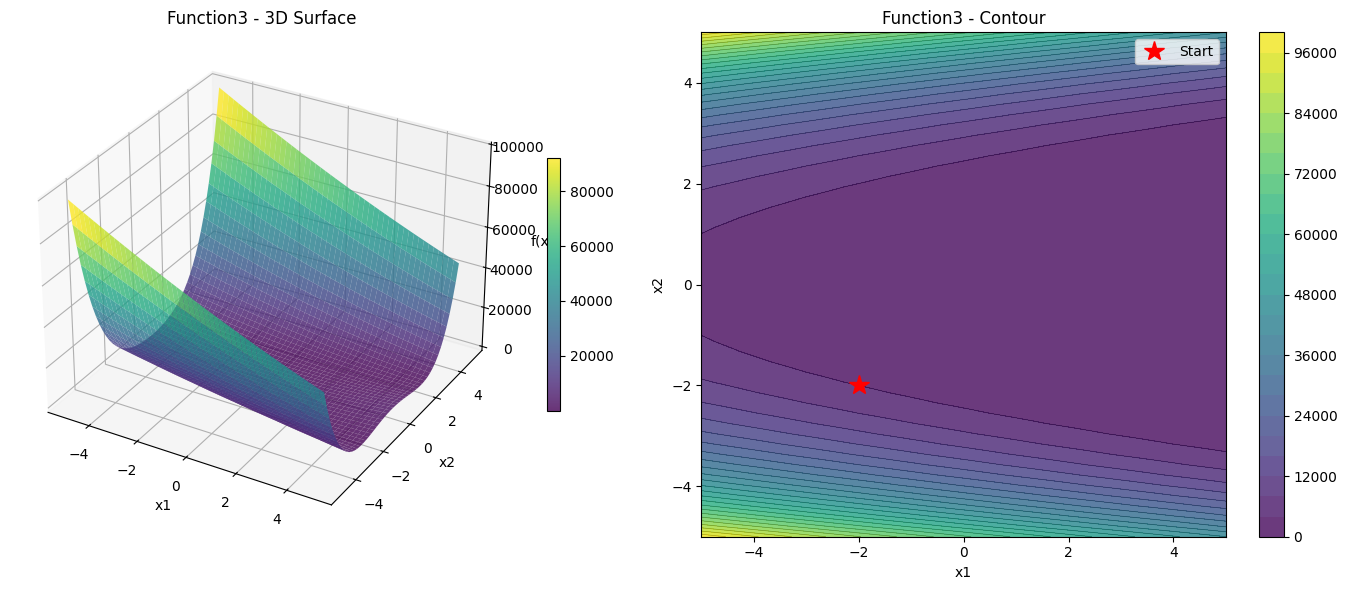

In [86]:
# 3D Surface Plot
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title(f'{FUNCTION_NAME} - 3D Surface')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Contour Plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(X0[0], X0[1], 'r*', markersize=15, label='Start', zorder=10)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title(f'{FUNCTION_NAME} - Contour')
ax2.legend()
fig.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()


---
## 1️⃣ SGD (Stochastic Gradient Descent)


In [87]:
print("="*70)
print("SGD")
print("="*70)
print(f"Parameters: lr={sgd_lr}, max_iter={MAX_ITER}")

x_sgd, history_sgd = sgd(bb, FUNCTION_NAME, X0, learning_rate=sgd_lr, max_iter=MAX_ITER, tol=TOLERANCE)
f_sgd = bb.evaluate(FUNCTION_NAME, x_sgd.tolist())

print(f"\nResults:")
print(f"  Final x: {x_sgd}")
print(f"  Final f(x): {f_sgd:.10e}")
print(f"  Iterations: {len(history_sgd)}")


SGD
Parameters: lr=0.0001, max_iter=200

Results:
  Final x: [-0.018789 -0.003723]
  Final f(x): 2.2470953510e+00
  Iterations: 200


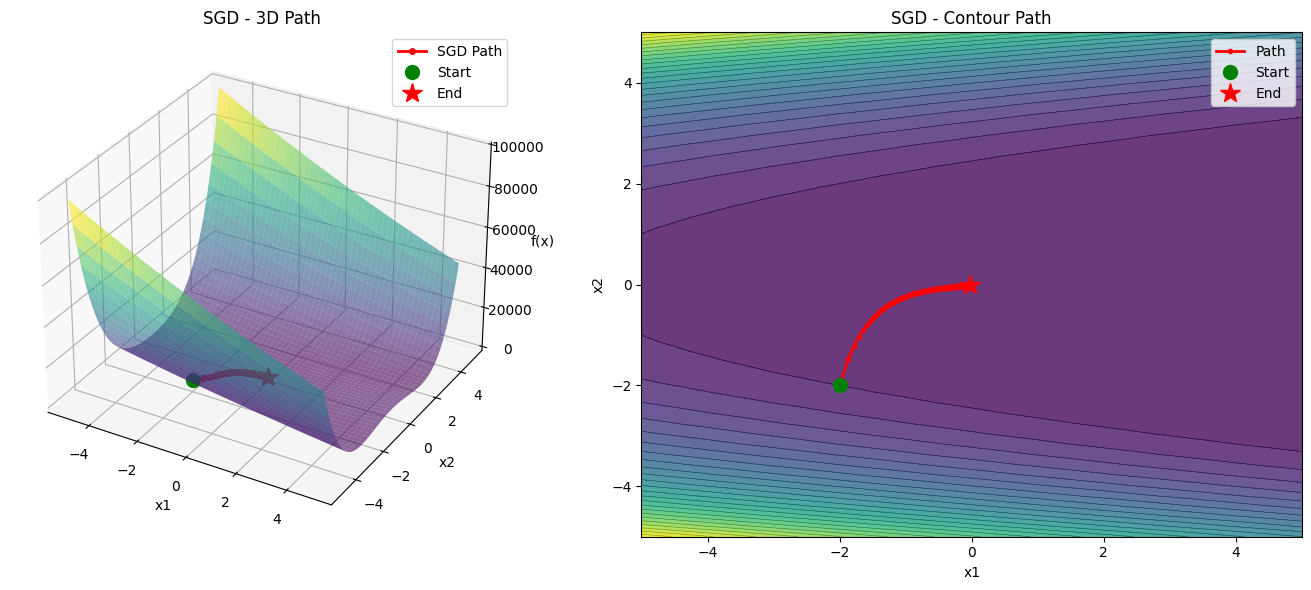

In [88]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_sgd]
path_y = [h[1][1] for h in history_sgd]
path_z = [h[2] for h in history_sgd]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='SGD Path')
ax1.plot([X0[0]], [X0[1]], [history_sgd[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('SGD - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('SGD - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 2️⃣ Momentum


In [89]:
print("="*70)
print("Momentum")
print("="*70)
print(f"Parameters: lr={momentum_lr}, beta={momentum_beta}, max_iter={MAX_ITER}")

x_momentum, history_momentum = momentum(bb, FUNCTION_NAME, X0, learning_rate=momentum_lr, beta=momentum_beta, max_iter=MAX_ITER, tol=TOLERANCE)
f_momentum = bb.evaluate(FUNCTION_NAME, x_momentum.tolist())

print(f"\nResults:")
print(f"  Final x: {x_momentum}")
print(f"  Final f(x): {f_momentum:.10e}")
print(f"  Iterations: {len(history_momentum)}")


Momentum
Parameters: lr=0.0001, beta=0.9, max_iter=200

Results:
  Final x: [ 0.702093 -0.833151]
  Final f(x): 4.8034430996e+00
  Iterations: 200


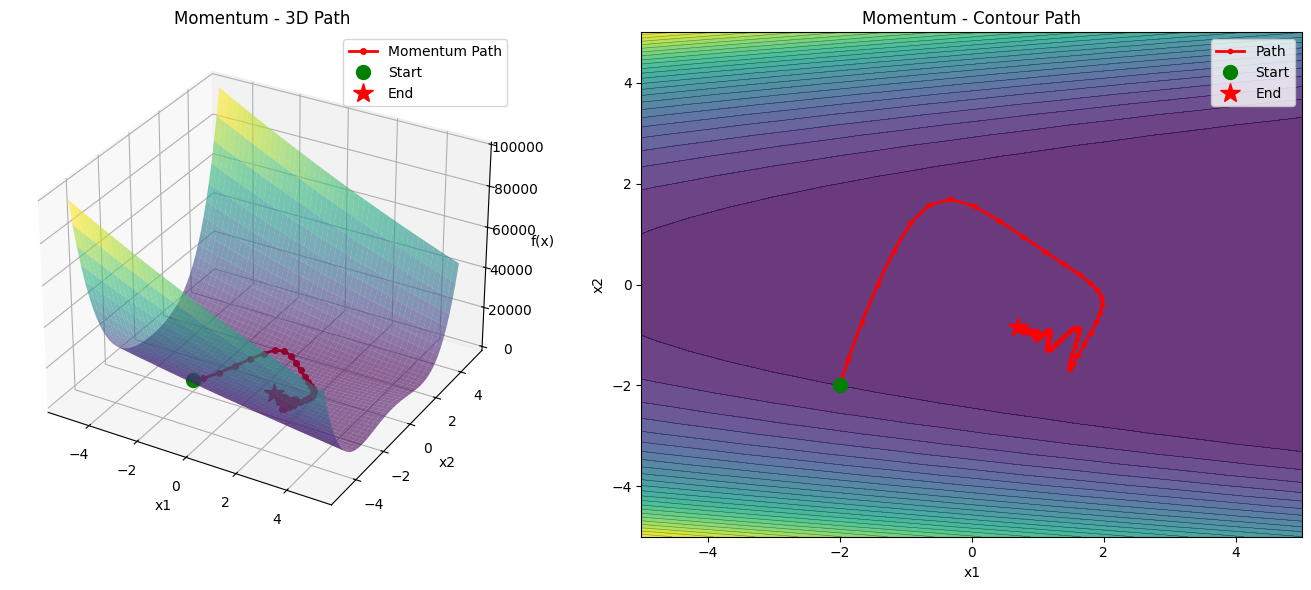

In [90]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_momentum]
path_y = [h[1][1] for h in history_momentum]
path_z = [h[2] for h in history_momentum]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='Momentum Path')
ax1.plot([X0[0]], [X0[1]], [history_momentum[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('Momentum - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Momentum - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 3️⃣ RMSProp


In [91]:
print("="*70)
print("RMSProp")
print("="*70)
print(f"Parameters: lr={rmsprop_lr}, beta={rmsprop_beta}, max_iter={MAX_ITER}")

x_rmsprop, history_rmsprop = rmsprop(bb, FUNCTION_NAME, X0, learning_rate=rmsprop_lr, beta=rmsprop_beta, max_iter=MAX_ITER, tol=TOLERANCE)
f_rmsprop = bb.evaluate(FUNCTION_NAME, x_rmsprop.tolist())

print(f"\nResults:")
print(f"  Final x: {x_rmsprop}")
print(f"  Final f(x): {f_rmsprop:.10e}")
print(f"  Iterations: {len(history_rmsprop)}")


RMSProp
Parameters: lr=0.01, beta=0.9, max_iter=200

Results:
  Final x: [-0.167313 -0.334141]
  Final f(x): 1.1618196586e+01
  Iterations: 200


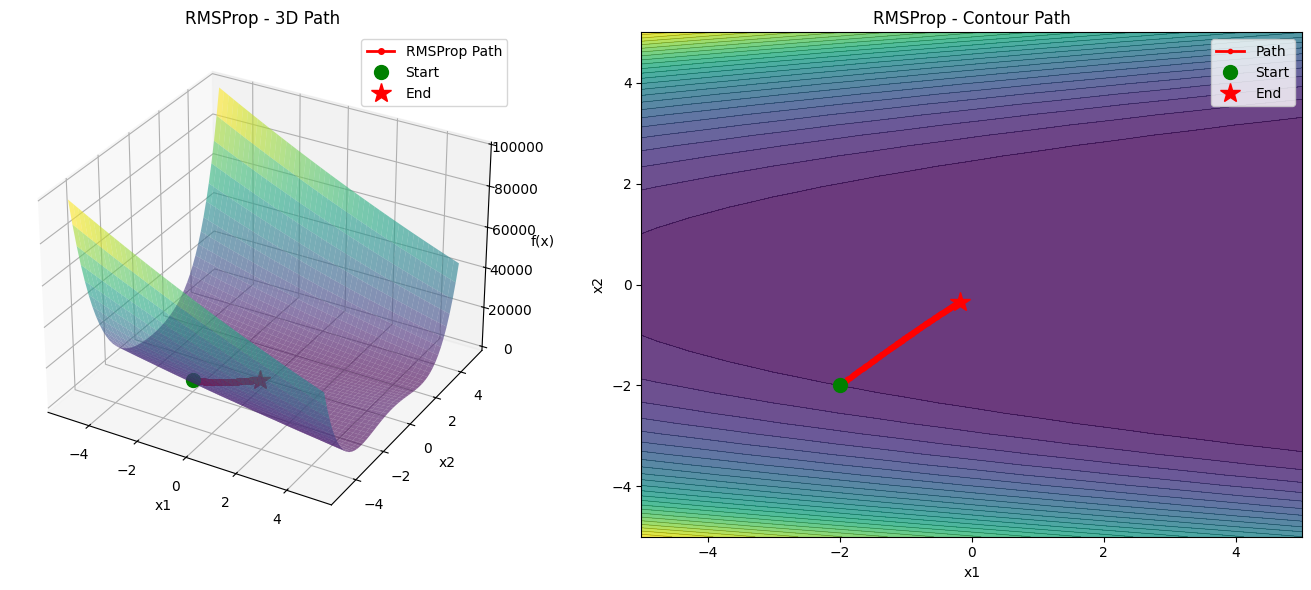

In [92]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_rmsprop]
path_y = [h[1][1] for h in history_rmsprop]
path_z = [h[2] for h in history_rmsprop]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='RMSProp Path')
ax1.plot([X0[0]], [X0[1]], [history_rmsprop[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('RMSProp - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('RMSProp - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 4️⃣ Adam


In [93]:
print("="*70)
print("Adam")
print("="*70)
print(f"Parameters: lr={adam_lr}, beta1={adam_beta1}, beta2={adam_beta2}, max_iter={800}")

x_adam, history_adam = adam(bb, FUNCTION_NAME, X0, learning_rate=adam_lr, beta1=adam_beta1, beta2=adam_beta2, max_iter=800, tol=TOLERANCE)
f_adam = bb.evaluate(FUNCTION_NAME, x_adam.tolist())

print(f"\nResults:")
print(f"  Final x: {x_adam}")
print(f"  Final f(x): {f_adam:.10e}")
print(f"  Iterations: {len(history_adam)}")


Adam
Parameters: lr=0.05, beta1=0.9, beta2=0.999, max_iter=800

Results:
  Final x: [ 0.058574 -0.23846 ]
  Final f(x): 2.7874823397e+00
  Iterations: 800


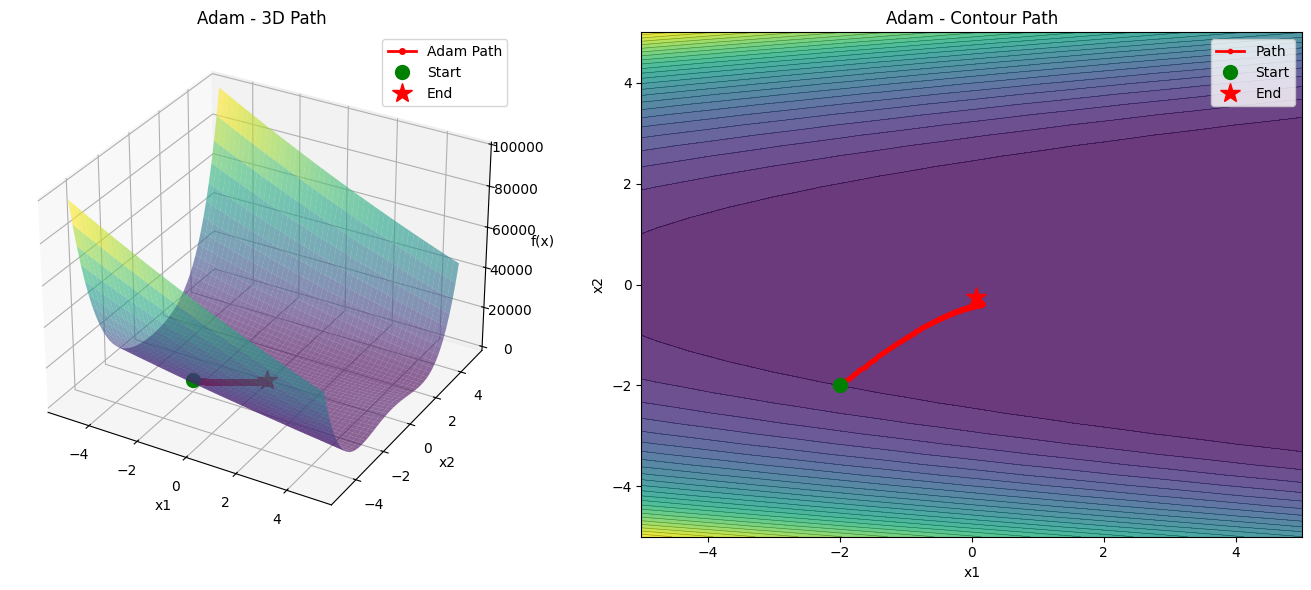

In [94]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_adam]
path_y = [h[1][1] for h in history_adam]
path_z = [h[2] for h in history_adam]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='Adam Path')
ax1.plot([X0[0]], [X0[1]], [history_adam[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('Adam - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Adam - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 5️⃣ Coordinate Search


In [95]:
print("="*70)
print("Coordinate Search")
print("="*70)
print(f"Parameters: step_size={coord_step_size}, reduction={coord_reduction}, max_iter={MAX_ITER}")

x_coord, history_coord = coordinate_search(bb, FUNCTION_NAME, X0, step_size=coord_step_size, reduction_factor=coord_reduction, max_iter=MAX_ITER, tol=TOLERANCE)
f_coord = bb.evaluate(FUNCTION_NAME, x_coord.tolist())

print(f"\nResults:")
print(f"  Final x: {x_coord}")
print(f"  Final f(x): {f_coord:.10e}")
print(f"  Iterations: {len(history_coord)}")


Coordinate Search
Parameters: step_size=0.1, reduction=0.5, max_iter=200
Coordinate Search: 200 iterations, final step size: 0.001563

Results:
  Final x: [0.5625   0.751563]
  Final f(x): 1.1684988181e+00
  Iterations: 200


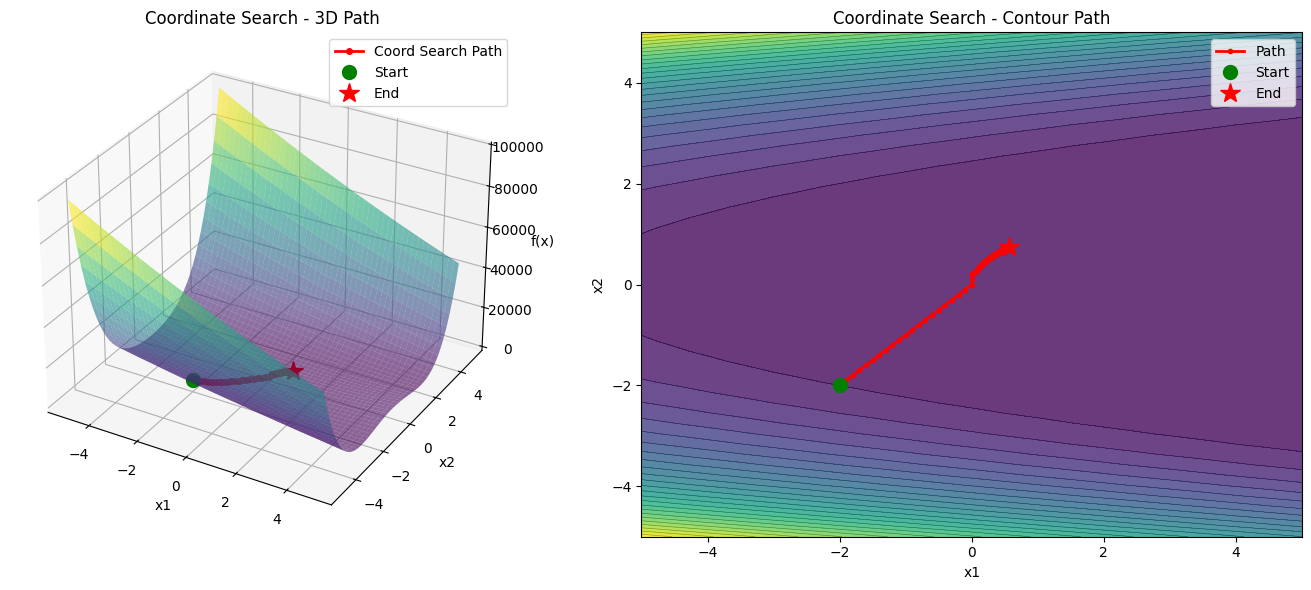

In [96]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_coord]
path_y = [h[1][1] for h in history_coord]
path_z = [h[2] for h in history_coord]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='Coord Search Path')
ax1.plot([X0[0]], [X0[1]], [history_coord[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('Coordinate Search - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Coordinate Search - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 6️⃣ Hooke & Jeeves


In [97]:
print("="*70)
print("Hooke & Jeeves")
print("="*70)
print(f"Parameters: step_size={hj_step_size}, reduction={hj_reduction}, max_iter={MAX_ITER}")

x_hj, history_hj = hooke_jeeves(bb, FUNCTION_NAME, X0, step_size=hj_step_size, reduction_factor=hj_reduction, max_iter=MAX_ITER, tol=TOLERANCE)
f_hj = bb.evaluate(FUNCTION_NAME, x_hj.tolist())

print(f"\nResults:")
print(f"  Final x: {x_hj}")
print(f"  Final f(x): {f_hj:.10e}")
print(f"  Iterations: {len(history_hj)}")


Hooke & Jeeves
Parameters: step_size=0.1, reduction=0.5, max_iter=200
Hooke & Jeeves: 200 iterations, final step size: 0.000391

Results:
  Final x: [0.768359 0.876953]
  Final f(x): 1.1167065651e+00
  Iterations: 200


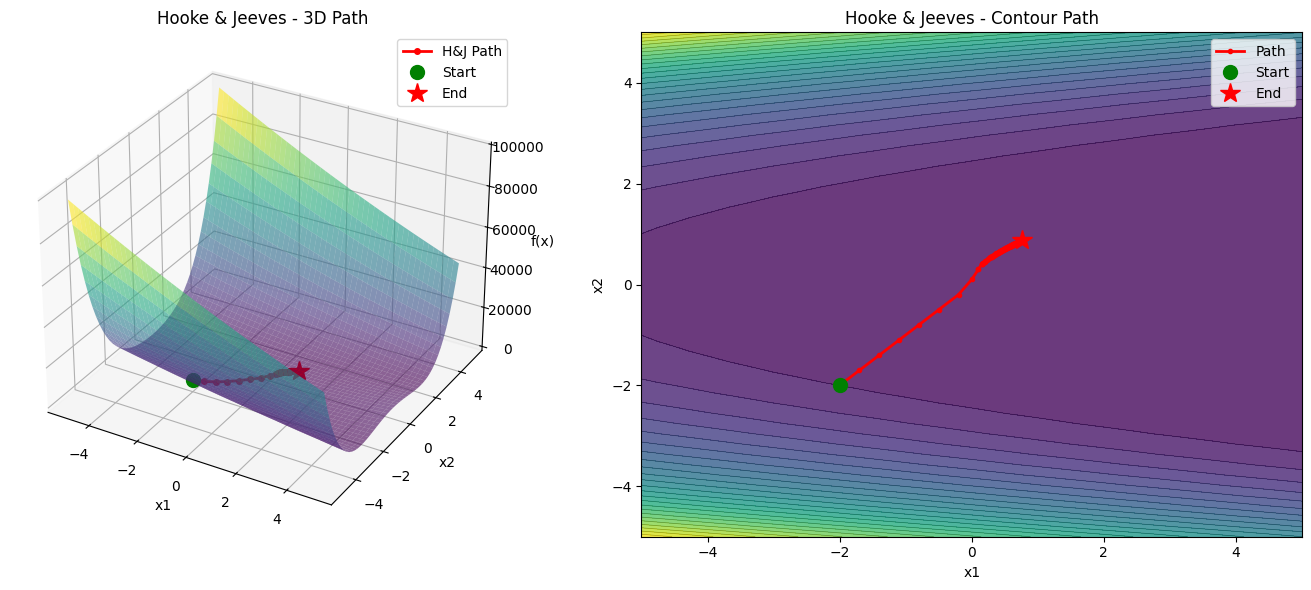

In [98]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_hj]
path_y = [h[1][1] for h in history_hj]
path_z = [h[2] for h in history_hj]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='H&J Path')
ax1.plot([X0[0]], [X0[1]], [history_hj[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('Hooke & Jeeves - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Hooke & Jeeves - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 7️⃣ Nelder-Mead


In [99]:
print("="*70)
print("Nelder-Mead")
print("="*70)
print(f"Parameters: alpha={nm_alpha}, gamma={nm_gamma}, rho={nm_rho}, sigma={nm_sigma}, max_iter={MAX_ITER}")

x_nm, history_nm = nelder_mead(bb, FUNCTION_NAME, X0, max_iter=MAX_ITER, tol=TOLERANCE, alpha=nm_alpha, gamma=nm_gamma, rho=nm_rho, sigma=nm_sigma)
f_nm = bb.evaluate(FUNCTION_NAME, x_nm.tolist())

print(f"\nResults:")
print(f"  Final x: {x_nm}")
print(f"  Final f(x): {f_nm:.10e}")
print(f"  Iterations: {len(history_nm)}")


Nelder-Mead
Parameters: alpha=1.0, gamma=2.0, rho=0.5, sigma=0.5, max_iter=200
Nelder-Mead converged after 67 iterations

Results:
  Final x: [1. 1.]
  Final f(x): 1.1000000000e+00
  Iterations: 68


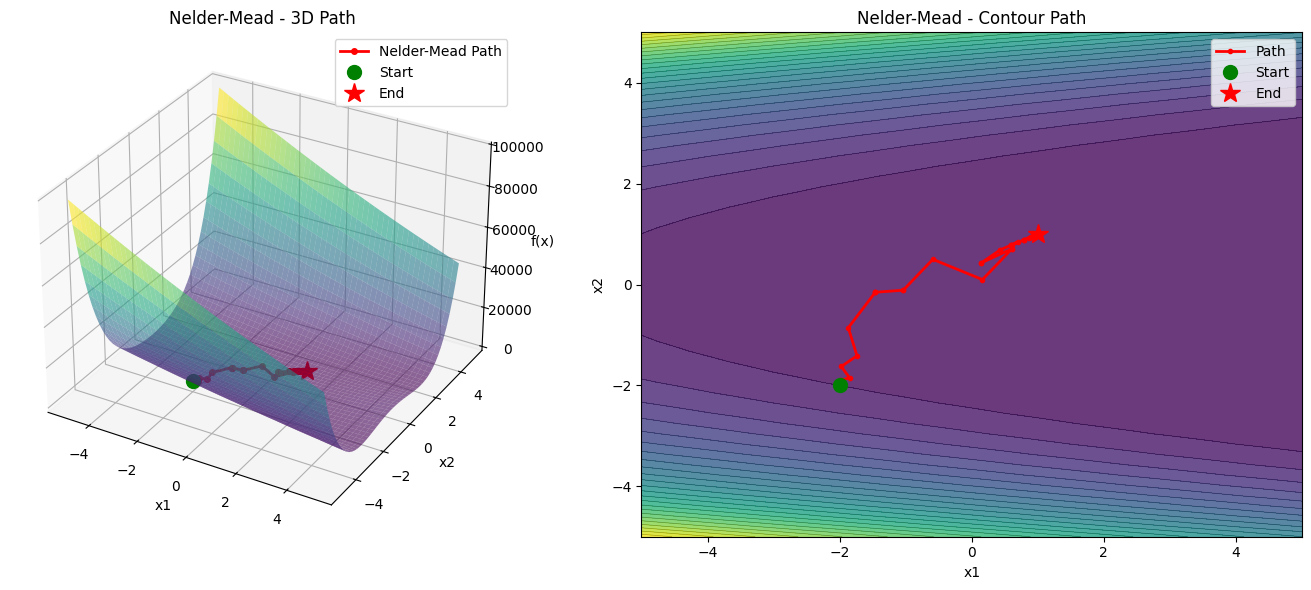

In [100]:
# Visualisierung mit Pfad
fig = plt.figure(figsize=(14, 6))

# 3D mit Pfad
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
path_x = [h[1][0] for h in history_nm]
path_y = [h[1][1] for h in history_nm]
path_z = [h[2] for h in history_nm]
ax1.plot(path_x, path_y, path_z, 'r.-', linewidth=2, markersize=8, label='Nelder-Mead Path')
ax1.plot([X0[0]], [X0[1]], [history_nm[0][2]], 'go', markersize=10, label='Start')
ax1.plot([path_x[-1]], [path_y[-1]], [path_z[-1]], 'r*', markersize=15, label='End')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
ax1.set_title('Nelder-Mead - 3D Path')
ax1.legend()

# Contour mit Pfad
ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax2.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(path_x, path_y, 'r.-', linewidth=2, markersize=6, label='Path')
ax2.plot(X0[0], X0[1], 'go', markersize=10, label='Start')
ax2.plot(path_x[-1], path_y[-1], 'r*', markersize=15, label='End')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Nelder-Mead - Contour Path')
ax2.legend()

plt.tight_layout()
plt.show()


---
## 📊 Final Summary


In [101]:
print("\n" + "="*70)
print("FINAL SUMMARY - Function3")
print("="*70)

results = [
    ("SGD", f_sgd, len(history_sgd)),
    ("Momentum", f_momentum, len(history_momentum)),
    ("RMSProp", f_rmsprop, len(history_rmsprop)),
    ("Adam", f_adam, len(history_adam)),
    ("Coordinate Search", f_coord, len(history_coord)),
    ("Hooke & Jeeves", f_hj, len(history_hj)),
    ("Nelder-Mead", f_nm, len(history_nm))
]

results_sorted = sorted(results, key=lambda x: x[1])

print(f"\n{'Rank':<5} {'Optimizer':<20} {'Final f(x)':<20} {'Iterations':<12}")
print("-"*70)
for rank, (name, f_val, iters) in enumerate(results_sorted, 1):
    marker = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{marker} {rank:<3} {name:<20} {f_val:<20.10e} {iters:<12}")

print("\n" + "="*70)



FINAL SUMMARY - Function3

Rank  Optimizer            Final f(x)           Iterations  
----------------------------------------------------------------------
🥇 1   Nelder-Mead          1.1000000000e+00     68          
🥈 2   Hooke & Jeeves       1.1167065651e+00     200         
🥉 3   Coordinate Search    1.1684988181e+00     200         
   4   SGD                  2.2470953510e+00     200         
   5   Adam                 2.7874823397e+00     800         
   6   Momentum             4.8034430996e+00     200         
   7   RMSProp              1.1618196586e+01     200         

